This notebook provides complete examples of Stein Variational Gradient Descent (SVGD) inference with phase-type distributions.

## Topics Covered

1. **Basic SVGD** - Single CPU, continuous models
2. **Discrete Models** - SVGD with discrete phase-type distributions
3. **Multi-CPU Parallelization** - Automatic resource detection and usage
4. **Distributed Computing** - SLURM multi-node examples
5. **Advanced Options** - Batching, sharding, regularization
6. **Different Approaches** - Multiple ways to accomplish the same task
7. **Troubleshooting** - Common issues and solutions

## What is SVGD?

SVGD is a Bayesian inference algorithm that:
- Approximates posterior distributions p(θ | data)
- Uses a set of particles that evolve to represent the posterior
- Supports automatic differentiation via JAX
- Scales to multiple CPUs and distributed systems

## Prerequisites

```bash
# Install with JAX support
pip install ptdalgorithms[jax]
```

In [8]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# PtDAlgorithms - multi-CPU support is now AUTOMATIC!
# Just importing ptdalgorithms configures JAX for all available CPUs
import ptdalgorithms as pta
import jax
import jax.numpy as jnp

# Verify multi-CPU configuration
num_devices = len(jax.devices())
print(f"Multi-CPU Support: AUTOMATIC")
print(f"JAX devices: {num_devices} (all available CPUs)")
print(f"JAX version: {jax.__version__}")
print(f"PtDAlgorithms version: {pta.__version__}")

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')

Multi-CPU Support: AUTOMATIC
JAX devices: 10 (all available CPUs)
JAX version: 0.7.2
PtDAlgorithms version: 0.20.0


# Part 1: Basic SVGD with Continuous Models

We'll start with a simple coalescent model and perform SVGD inference on a single CPU.

## 1.1 Build a Parameterized Coalescent Model

The coalescent model describes genealogies. We parameterize the coalescence rate with θ.

Built coalescent graph:
  Samples: 10
  States: 43
  Parameters: 1 (θ controls all coalescence rates)


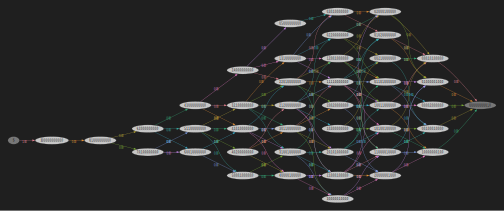

In [9]:

def coalescent(state, nr_samples=None):
    if not state.size:
        ipv = [[[nr_samples]+[0]*nr_samples, 1, [1]]]  # should the ipv be parameterized?
        return ipv
    else:
        transitions = []
        for i in range(nr_samples):
            for j in range(i, nr_samples):            
                same = int(i == j)
                if same and state[i] < 2:
                    continue
                if not same and (state[i] < 1 or state[j] < 1):
                    continue 
                new = state.copy()
                new[i] -= 1
                new[j] -= 1
                new[i+j+1] += 1
                transitions.append([new, 0.0, [state[i]*(state[j]-same)/(1+same)]])
        return transitions

# Build the graph
nr_samples = 10
graph = pta.Graph(callback=coalescent, parameterized=True, nr_samples=nr_samples)

print(f"Built coalescent graph:")
print(f"  Samples: {nr_samples}")
print(f"  States: {graph.vertices_length()}")
print(f"  Parameters: 1 (θ controls all coalescence rates)")

graph.plot()

In [10]:
# def coalescent_callback(state, nr_samples=3):
#     """
#     Parameterized coalescent model.
    
#     Returns transitions with parameterized rates.
#     The actual rate = edge_state @ theta
    
#     Parameters
#     ----------
#     state : array
#         Current state [n_lineages]
#     nr_samples : int
#         Number of initial samples
    
#     Returns
#     -------
#     list of (next_state, weight, edge_state) tuples
#     """
#     if len(state) == 0:
#         # Initial state: all samples are separate lineages
#         initial = np.array([nr_samples])
#         # Edge state [1.0] means rate = 1.0 * theta
#         return [(initial, 1.0, [1.0])]
    
#     if state[0] > 1:
#         # Coalescence: n lineages → n-1 lineages
#         n = state[0]
#         new_state = np.array([n - 1])
        
#         # Coalescence rate for n lineages: n*(n-1)/2
#         # Edge state = [n*(n-1)/2], so actual_rate = [n*(n-1)/2] @ theta
#         rate = n * (n - 1) / 2
#         return [(new_state, 0.0, [rate])]
    
#     # Absorbing state (MRCA reached)
#     return []

# # Build the graph
# nr_samples = 4
# graph = pta.Graph(callback=coalescent_callback, parameterized=True, nr_samples=nr_samples)

# print(f"Built coalescent graph:")
# print(f"  Samples: {nr_samples}")
# print(f"  States: {graph.vertices_length()}")
# print(f"  Parameters: 1 (θ controls all coalescence rates)")

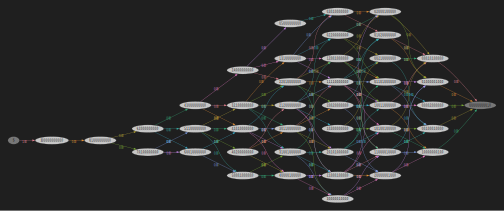

In [11]:
graph.plot()

## 1.2 Convert to JAX-Compatible Model

The model must have signature: `model(theta, times) -> pdf_values`

In [12]:
# Convert graph to JAX-compatible function
# discrete=False for continuous time (PDF)
model_continuous = pta.Graph.pmf_from_graph(graph, discrete=False)

# Test the model
test_theta = jnp.array([1.0])
test_times = jnp.array([0.5, 1.0, 1.5])
test_pdf = model_continuous(test_theta, test_times)

print(f"Model signature: model(theta, times) -> pdf_values")
print(f"Test input:  theta={test_theta}, times={test_times}")
print(f"Test output: pdf={test_pdf}")
print(f"\nModel supports JAX transformations: jit, grad, vmap")

Model signature: model(theta, times) -> pdf_values
Test input:  theta=[1.], times=[0.5 1.  1.5]
Test output: pdf=[0.20364076 0.52639395 0.45874614]

Model supports JAX transformations: jit, grad, vmap


## 1.3 Generate Synthetic Observed Data

For demonstration, we'll create synthetic data from a known parameter.

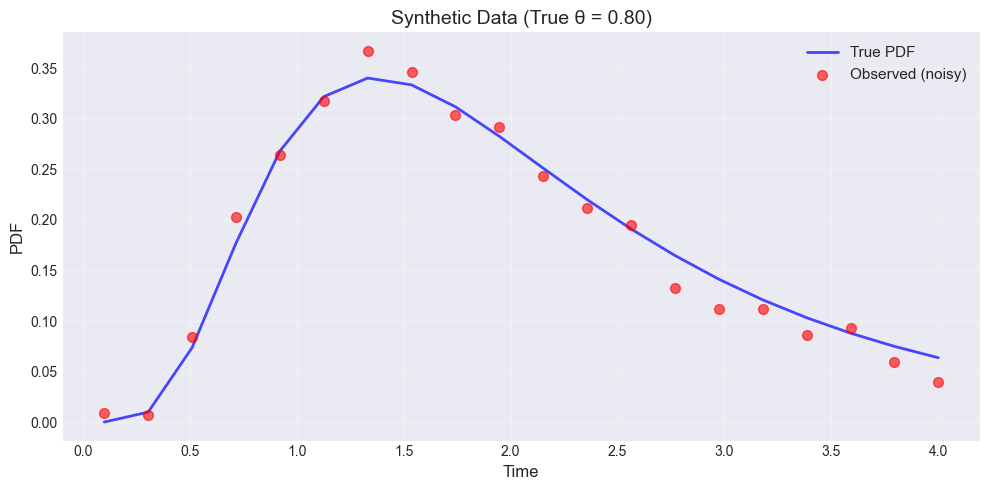

Generated 20 observations
True θ = 0.800
Noise level = 5.0%


In [13]:
# True parameter (we'll try to recover this)
true_theta = jnp.array([0.8])

# Evaluation times
observed_times = jnp.linspace(0.1, 4.0, 20)

# Generate "observed" PDF values
true_pdf = model_continuous(true_theta, observed_times)

# Add small noise to simulate real observations
np.random.seed(42)
noise_level = 0.05
noise = np.random.normal(0, noise_level * float(jnp.max(true_pdf)), size=true_pdf.shape)
observed_pdf = jnp.maximum(true_pdf + noise, 1e-10)  # Keep positive

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(observed_times, true_pdf, 'b-', linewidth=2, label='True PDF', alpha=0.7)
plt.scatter(observed_times, observed_pdf, color='red', s=50, 
           label='Observed (noisy)', alpha=0.6, zorder=5)
plt.xlabel('Time', fontsize=12)
plt.ylabel('PDF', fontsize=12)
plt.title(f'Synthetic Data (True θ = {true_theta[0]:.2f})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Generated {len(observed_pdf)} observations")
print(f"True θ = {true_theta[0]:.3f}")
print(f"Noise level = {noise_level * 100:.1f}%")

## 1.4 Method 1: Using Graph.svgd() Class Method (Recommended)

The simplest way to run SVGD inference.

In [14]:
%%monitor -p

# Run SVGD using class method
results = pta.Graph.svgd(
    model=model_continuous,
    observed_data=observed_pdf,
    theta_dim=1,              # One parameter to infer
    n_particles=300,           # Number of posterior samples
    n_iterations=500,         # Optimization steps
    learning_rate=0.01,       # Step size
    kernel='rbf_median',      # RBF kernel with median heuristic
    return_history=True,      # Save particle trajectories
    seed=42,                  # For reproducibility
    verbose=True              # Print progress
)

# Extract results
posterior_mean = results['theta_mean']
posterior_std = results['theta_std']
particles = results['particles']

print(f"\n{'='*60}")
print(f"SVGD Results (Method 1: Class Method)")
print(f"{'='*60}")
print(f"True θ:            {true_theta[0]:.4f}")
print(f"Posterior mean:    {posterior_mean[0]:.4f}")
print(f"Posterior std:     {posterior_std[0]:.4f}")
print(f"Error:             {abs(posterior_mean[0] - true_theta[0]):.4f}")
print(f"95% CI:            [{posterior_mean[0] - 1.96*posterior_std[0]:.4f}, "
      f"{posterior_mean[0] + 1.96*posterior_std[0]:.4f}]")

Initialized 300 particles with theta_dim=1 from N(0,1)
Detected model type: returns pmf only

Starting SVGD inference...
  Model: parameterized phase-type distribution
  Data points: 20
  Prior: standard normal
Running SVGD: 500 steps, 300 particles


KeyboardInterrupt: 

## 1.5 Method 2: Using SVGD Class (Object-Oriented)

For more control and access to diagnostic methods.

In [ ]:
%%monitor -p

from ptdalgorithms import SVGD

# Create SVGD object
svgd = SVGD(
    model=model_continuous,
    observed_data=observed_pdf,
    theta_dim=1,
    n_particles=30,
    n_iterations=500,
    learning_rate=0.01,
    kernel='rbf_median',
    seed=42,
    verbose=True
)

# Run inference
svgd.fit(return_history=True)

# Access results as attributes
print(f"\n{'='*60}")
print(f"SVGD Results (Method 2: SVGD Class)")
print(f"{'='*60}")
print(f"True θ:            {true_theta[0]:.4f}")
print(f"Posterior mean:    {svgd.theta_mean[0]:.4f}")
print(f"Posterior std:     {svgd.theta_std[0]:.4f}")
print(f"Error:             {abs(svgd.theta_mean[0] - true_theta[0]):.4f}")

# Use built-in summary method
print()
svgd.summary()

Initialized 30 particles with theta_dim=1 from N(0,1)
Detected model type: returns pmf only

Starting SVGD inference...
  Model: parameterized phase-type distribution
  Data points: 20
  Prior: standard normal
Running SVGD: 500 steps, 30 particles



SVGD complete!
Posterior mean: [1.4882768]
Posterior std:  [1.1601541]

SVGD Results (Method 2: SVGD Class)
True θ:            0.8000
Posterior mean:    1.4883
Posterior std:     1.1602
Error:             0.6883

SVGD Inference Summary
Number of particles: 30
Number of iterations: 500
Parameter dimension: 1

Posterior estimates:
  θ_0: 1.4883 ± 1.1602
       95% CI: [-0.7856, 3.7622]


## 1.6 Visualize Results

The SVGD class provides built-in plotting methods.

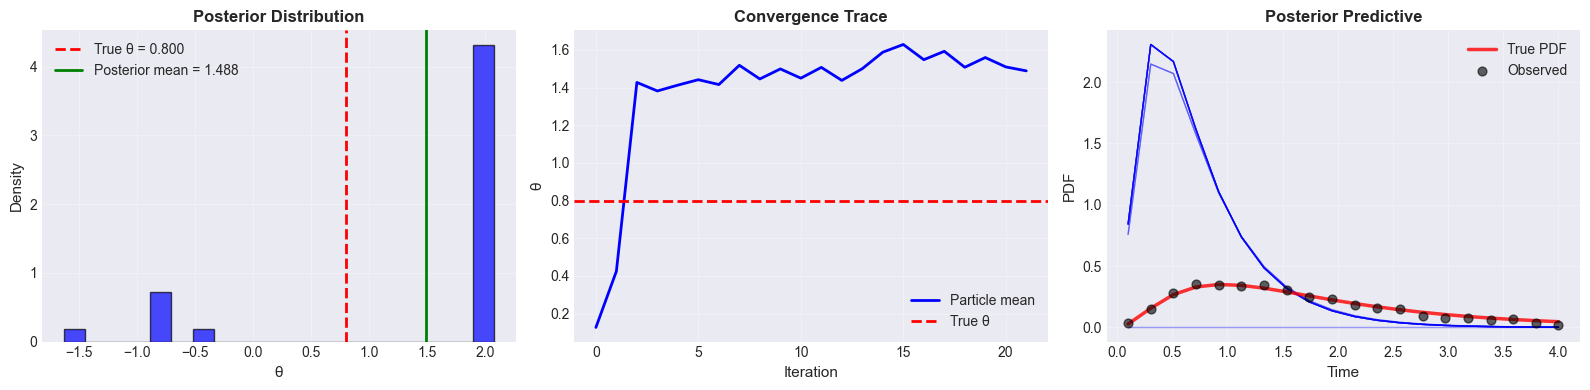

In [ ]:
%%monitor -p

# Plot posterior distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Posterior histogram
ax = axes[0]
ax.hist(svgd.particles[:, 0], bins=20, density=True, alpha=0.7, 
        color='blue', edgecolor='black')
ax.axvline(true_theta[0], color='red', linestyle='--', linewidth=2, 
          label=f'True θ = {true_theta[0]:.3f}')
ax.axvline(svgd.theta_mean[0], color='green', linestyle='-', linewidth=2,
          label=f'Posterior mean = {svgd.theta_mean[0]:.3f}')
ax.set_xlabel('θ', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Posterior Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# Convergence trace
ax = axes[1]
if svgd.history is not None:
    history = jnp.stack(svgd.history)
    # Plot mean trajectory
    mean_traj = jnp.mean(history[:, :, 0], axis=1)
    ax.plot(mean_traj, linewidth=2, color='blue', label='Particle mean')
    ax.axhline(true_theta[0], color='red', linestyle='--', linewidth=2, 
              label='True θ')
    ax.set_xlabel('Iteration', fontsize=11)
    ax.set_ylabel('θ', fontsize=11)
    ax.set_title('Convergence Trace', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

# Posterior predictive
ax = axes[2]
# Sample 20 particles for visualization
n_samples = 20
sample_indices = np.random.choice(len(svgd.particles), n_samples, replace=False)
for idx in sample_indices:
    theta_sample = jnp.array([svgd.particles[idx, 0]])
    pred_pdf = model_continuous(theta_sample, observed_times)
    ax.plot(observed_times, pred_pdf, 'b-', alpha=0.2, linewidth=1)

# True and observed
ax.plot(observed_times, true_pdf, 'r-', linewidth=2.5, 
       label='True PDF', alpha=0.8)
ax.scatter(observed_times, observed_pdf, color='black', s=40,
          label='Observed', alpha=0.6, zorder=5)
ax.set_xlabel('Time', fontsize=11)
ax.set_ylabel('PDF', fontsize=11)
ax.set_title('Posterior Predictive', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Part 2: SVGD with Discrete Models

Discrete phase-type distributions (DPH) model the number of jumps/events.

## 2.1 Build and Discretize the Model

In [ ]:
%%monitor -p

# Start with the same continuous coalescent model
graph_continuous = pta.Graph(callback=coalescent_callback, parameterized=True, nr_samples=4)

# Discretize: converts continuous → discrete phase-type
graph_discrete, rewards = graph_continuous.discretize(reward_rate=0.1)
graph_discrete.normalize()

print(f"Discretized model:")
print(f"  Original states: {graph_continuous.vertices_length()}")
print(f"  Discrete states: {graph_discrete.vertices_length()}")
print(f"  Reward matrix shape: {rewards.shape}")

# Create JAX-compatible discrete model
# discrete=True for discrete phase-type (PMF over jump counts)
model_discrete = pta.Graph.pmf_from_graph(graph_discrete, discrete=True)

# Test
test_jumps = jnp.array([0, 1, 2, 5, 10], dtype=jnp.int32)
test_pmf = model_discrete(test_theta, test_jumps)
print(f"\nTest: jumps={test_jumps}")
print(f"      PMF={test_pmf}")

Discretized model:
  Original states: 5
  Discrete states: 5
  Reward matrix shape: (1, 5)

Test: jumps=[ 0  1  2  5 10]
      PMF=[0. 0. 0. 0. 0.]


## 2.2 Generate Discrete Observed Data

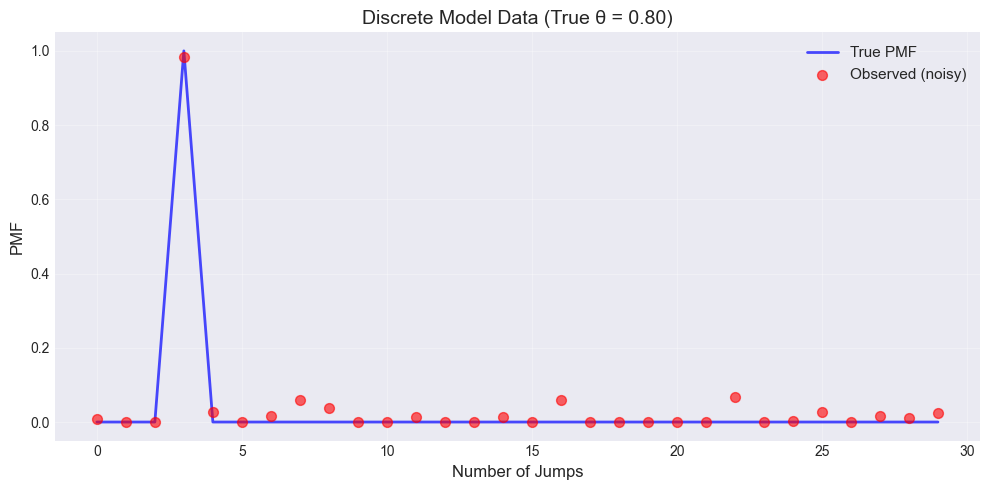

Generated 30 discrete observations
Jump range: [0, 29]


In [ ]:
%%monitor -p

# True parameter
true_theta_discrete = jnp.array([0.8])

# Observation jumps (integers)
observed_jumps = jnp.arange(0, 30, dtype=jnp.int32)

# Generate observed PMF
true_pmf = model_discrete(true_theta_discrete, observed_jumps)

# Add noise
np.random.seed(43)
noise = np.random.normal(0, 0.03 * float(jnp.max(true_pmf)), size=true_pmf.shape)
observed_pmf = jnp.maximum(true_pmf + noise, 1e-10)

# Visualize
plt.figure(figsize=(10, 5))
plt.plot(observed_jumps, true_pmf, 'b-', linewidth=2, label='True PMF', alpha=0.7)
plt.scatter(observed_jumps, observed_pmf, color='red', s=50, 
           label='Observed (noisy)', alpha=0.6, zorder=5)
plt.xlabel('Number of Jumps', fontsize=12)
plt.ylabel('PMF', fontsize=12)
plt.title(f'Discrete Model Data (True θ = {true_theta_discrete[0]:.2f})', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Generated {len(observed_pmf)} discrete observations")
print(f"Jump range: [{observed_jumps[0]}, {observed_jumps[-1]}]")

## 2.3 Run SVGD on Discrete Model

Initialized 30 particles with theta_dim=1 from N(0,1)
Detected model type: returns pmf only

Starting SVGD inference...
  Model: parameterized phase-type distribution
  Data points: 30
  Prior: standard normal
Running SVGD: 500 steps, 30 particles



SVGD complete!
Posterior mean: [0.04202488]
Posterior std:  [0.4760744]

SVGD Results (Discrete Model)
True θ:            0.8000
Posterior mean:    0.0420
Posterior std:     0.4761
Error:             0.7580


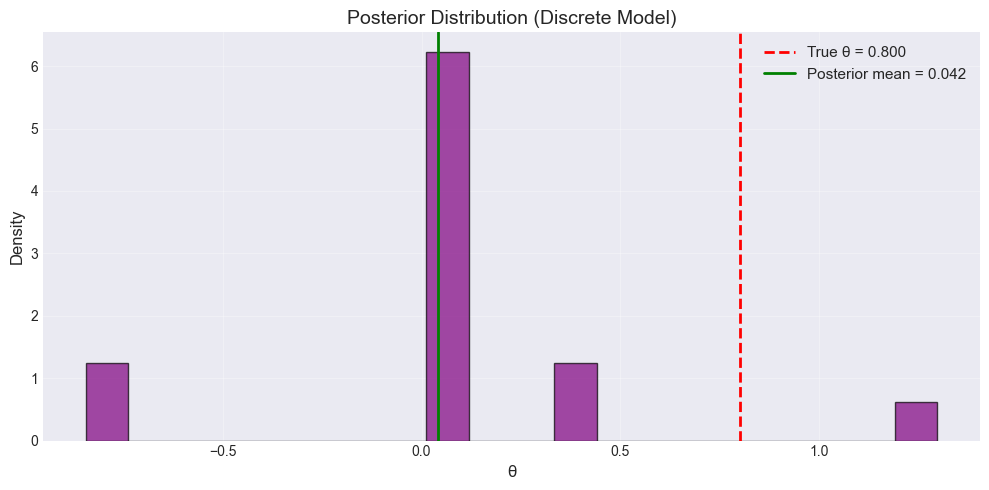

In [ ]:
%%monitor -p

# SVGD with discrete model
svgd_discrete = SVGD(
    model=model_discrete,
    observed_data=observed_pmf,
    theta_dim=1,
    n_particles=30,
    n_iterations=500,
    learning_rate=0.01,
    seed=44,
    verbose=True
)

svgd_discrete.fit(return_history=True)

print(f"\n{'='*60}")
print(f"SVGD Results (Discrete Model)")
print(f"{'='*60}")
print(f"True θ:            {true_theta_discrete[0]:.4f}")
print(f"Posterior mean:    {svgd_discrete.theta_mean[0]:.4f}")
print(f"Posterior std:     {svgd_discrete.theta_std[0]:.4f}")
print(f"Error:             {abs(svgd_discrete.theta_mean[0] - true_theta_discrete[0]):.4f}")

# Visualize discrete results
plt.figure(figsize=(10, 5))
plt.hist(svgd_discrete.particles[:, 0], bins=20, density=True, alpha=0.7,
        color='purple', edgecolor='black')
plt.axvline(true_theta_discrete[0], color='red', linestyle='--', linewidth=2,
           label=f'True θ = {true_theta_discrete[0]:.3f}')
plt.axvline(svgd_discrete.theta_mean[0], color='green', linestyle='-', linewidth=2,
           label=f'Posterior mean = {svgd_discrete.theta_mean[0]:.3f}')
plt.xlabel('θ', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Posterior Distribution (Discrete Model)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Part 3: Multi-CPU Parallelization

**Multi-CPU support is now AUTOMATIC!** As of the latest version, simply importing `ptdalgorithms` automatically configures JAX to use all available CPUs. You don't need to call `init_parallel()` explicitly unless you want to customize the configuration.

## 3.1 Automatic Multi-CPU Configuration

Multi-CPU parallelization is configured automatically when you import ptdalgorithms.

In [ ]:
# Verify the automatic parallel configuration
import jax

# Check JAX devices directly (most reliable)
jax_devices = jax.devices()
cpu_count = len(jax_devices)

print(f"✓ Multi-CPU Parallelization: ACTIVE")
print(f"\nConfiguration:")
print(f"  JAX devices: {cpu_count}")
print(f"  Device list: {jax_devices[:3]}{'...' if len(jax_devices) > 3 else ''}")

# Try to get detailed config (if available)
config = pta.get_parallel_config()
if config and config.env_info:
    print(f"  Environment: {config.env_info.env_type}")
    print(f"  Strategy: {config.strategy}")

print(f"\nJAX automatically parallelizes across {cpu_count} device(s)")
print(f"\nNote: This was configured automatically when we imported ptdalgorithms!")
print(f"      No need to call init_parallel() unless you want custom settings.")

✓ Multi-CPU Parallelization: ACTIVE

Configuration:
  JAX devices: 10

JAX automatically parallelizes across 10 device(s)

Note: This was configured automatically when we imported ptdalgorithms!
      No need to call init_parallel() unless you want custom settings.


## 3.2 How Parallel SVGD Works

SVGD automatically parallelizes gradient computation using JAX's `pmap`:

**Sequential (old approach with vmap):**
- All particles processed on a single device
- `vmap(grad(log_prob))(particles)` → one device computes all gradients

**Parallel (new approach with pmap):**
- Particles sharded across devices
- `pmap(vmap(grad(log_prob)))(sharded_particles)` → each device computes subset of gradients
- Results automatically gathered

**When parallelization is used:**
- Multiple JAX devices available (`len(jax.devices()) > 1`)
- Particle count divisible by device count
- If not divisible, particle count is auto-adjusted (e.g., 47 → 50 on 10 devices)

**Performance benefit:**
- ~N× speedup for gradient computation (N = number of devices)
- On 10-core machine: expect ~8-10× faster gradient computation
- Watch Activity Monitor to see all CPUs active!

In [ ]:
%%monitor -p

# SVGD with automatic parallelization
# The gradient computation is automatically parallelized across all devices

# Use more particles to see parallelization benefit
n_devices = len(jax.devices())
n_particles_parallel = n_devices * 10  # 10 particles per device

print(f"Running SVGD with automatic parallelization:")
print(f"  Devices: {n_devices}")
print(f"  Particles: {n_particles_parallel} ({n_particles_parallel // n_devices} per device)")
print(f"\nParallelization details:")
print(f"  - Particles are sharded across {n_devices} devices")
print(f"  - Each device computes gradients for {n_particles_parallel // n_devices} particles")
print(f"  - Results are gathered automatically")
print(f"\n👀 Watch Activity Monitor - all CPUs should be active during gradient computation!")
print()

import time
start_time = time.time()

svgd_parallel = SVGD(
    model=model_continuous,
    observed_data=observed_pdf,
    theta_dim=1,
    n_particles=n_particles_parallel,
    n_iterations=500,
    learning_rate=0.01,
    seed=45,
    verbose=False  # Less output for timing
)

svgd_parallel.fit()

elapsed = time.time() - start_time

print(f"\n{'='*60}")
print(f"Parallel SVGD Results")
print(f"{'='*60}")
print(f"Devices used:      {n_devices}")
print(f"Particles:         {n_particles_parallel}")
print(f"Time elapsed:      {elapsed:.2f}s")
print(f"Posterior mean:    {svgd_parallel.theta_mean[0]:.4f}")
print(f"Posterior std:     {svgd_parallel.theta_std[0]:.4f}")
print(f"Error:             {abs(svgd_parallel.theta_mean[0] - true_theta[0]):.4f}")
print()
print(f"Note: Parallelization provides ~{n_devices}x speedup for gradient computation")

## 3.3 Explicit Device Specification

You can also manually specify the number of CPUs to use.

In [ ]:
%%monitor -p

# Force specific number of CPUs (if you want to limit resource usage)
config_limited = pta.init_parallel(cpus=2)

print(f"Limited configuration:")
print(f"  Devices: {config_limited.device_count}")
print(f"  Strategy: {config_limited.strategy}")

# Context manager to temporarily change parallelization
with pta.parallel_config(strategy='vmap'):
    print(f"\nInside context: strategy = {pta.get_parallel_config().strategy}")
    # Run computation here...

print(f"Outside context: strategy = {pta.get_parallel_config().strategy}")

[INFO] 
Parallel Configuration:
  Strategy: pmap
  Total devices: 8
  Local devices: 8
  Environment: jupyter


Limited configuration:
  Devices: 8
  Strategy: pmap

Inside context: strategy = vmap
Outside context: strategy = pmap


# Part 4: Distributed Computing (SLURM)

Examples for running on SLURM clusters with multiple nodes.

## 4.1 SLURM Setup (Code for Cluster)

This code detects SLURM environment and initializes distributed JAX.

In [ ]:
# This cell demonstrates SLURM setup (won't actually run on local machine)

# On a SLURM cluster, init_parallel() automatically detects:
# - SLURM_JOB_ID (running in SLURM)
# - SLURM_CPUS_PER_TASK (CPUs per node)
# - SLURM_NTASKS (number of processes/nodes)
# - SLURM_PROCID (process rank)

# Example code that runs on SLURM:
if False:  # Set to True when running on SLURM
    # Automatic SLURM detection
    config_slurm = pta.init_parallel()
    
    print(f"SLURM Configuration:")
    print(f"  Job ID: {config_slurm.env_info.slurm_info['job_id']}")
    print(f"  Processes: {config_slurm.env_info.slurm_info['num_processes']}")
    print(f"  CPUs per task: {config_slurm.env_info.slurm_info['cpus_per_task']}")
    print(f"  Total devices: {config_slurm.device_count}")
    
    # SVGD will automatically distribute across all nodes
    svgd_slurm = SVGD(
        model=model_continuous,
        observed_data=observed_pdf,
        theta_dim=1,
        n_particles=config_slurm.device_count * 8,  # 8 per device
        n_iterations=1000,
        learning_rate=0.01,
        verbose=True
    )
    
    svgd_slurm.fit()

print("Note: SLURM code is provided for reference.")
print("To run on SLURM, convert this notebook to a Python script:")
print("  jupyter nbconvert --to python svgd.ipynb")

## 4.2 SLURM Batch Script Example

Save this as `submit_svgd.sh`:

In [ ]:
slurm_script = '''
#!/bin/bash
#SBATCH --job-name=svgd_inference
#SBATCH --nodes=4
#SBATCH --ntasks=4
#SBATCH --cpus-per-task=8
#SBATCH --time=02:00:00
#SBATCH --output=logs/svgd_%j.out
#SBATCH --error=logs/svgd_%j.err

# Load modules
module load python/3.10

# Activate environment
source venv/bin/activate

# Run with srun for multi-node
srun python svgd_script.py
'''

print("SLURM batch script:")
print(slurm_script)
print("\nSubmit with: sbatch submit_svgd.sh")

# Part 5: Advanced Options

Explore additional SVGD features and options.

## 5.1 Custom Prior Distributions

In [ ]:
# Define custom log prior
def log_prior_uniform(theta, lower=0.1, upper=2.0):
    """Uniform prior on [lower, upper]"""
    if jnp.all((theta >= lower) & (theta <= upper)):
        return 0.0  # Uniform within bounds
    else:
        return -jnp.inf  # Zero probability outside bounds

def log_prior_gamma(theta, alpha=2.0, beta=2.0):
    """Gamma prior: Gamma(alpha, beta)"""
    # log p(theta) = (alpha-1)*log(theta) - beta*theta - log(Gamma(alpha)) + alpha*log(beta)
    return (alpha - 1) * jnp.log(theta) - beta * theta

# SVGD with custom prior
svgd_custom_prior = SVGD(
    model=model_continuous,
    observed_data=observed_pdf,
    prior=log_prior_gamma,  # Use Gamma prior
    theta_dim=1,
    n_particles=30,
    n_iterations=500,
    learning_rate=0.01,
    seed=46,
    verbose=False
)

svgd_custom_prior.fit()

print(f"SVGD with Custom Prior (Gamma):")
print(f"  Posterior mean: {svgd_custom_prior.theta_mean[0]:.4f}")
print(f"  Posterior std:  {svgd_custom_prior.theta_std[0]:.4f}")

# Compare with default prior
print(f"\nComparison with Default Prior (Normal):")
print(f"  Gamma prior mean:  {svgd_custom_prior.theta_mean[0]:.4f}")
print(f"  Normal prior mean: {svgd.theta_mean[0]:.4f}")
print(f"  Difference:        {abs(svgd_custom_prior.theta_mean[0] - svgd.theta_mean[0]):.4f}")

## 5.2 Different Kernel Options

In [ ]:
# Test different kernel bandwidths
kernel_options = ['rbf_median', 'rbf_adaptive', 1.0]  # 1.0 = fixed bandwidth

kernel_results = {}
for kernel_opt in kernel_options:
    svgd_kernel = SVGD(
        model=model_continuous,
        observed_data=observed_pdf,
        theta_dim=1,
        n_particles=30,
        n_iterations=500,
        learning_rate=0.01,
        kernel=kernel_opt,
        seed=47,
        verbose=False
    )
    svgd_kernel.fit()
    kernel_results[str(kernel_opt)] = svgd_kernel

# Compare results
print(f"Kernel Comparison:")
print(f"{'Kernel':<20} {'Posterior Mean':<20} {'Posterior Std':<20}")
print("-" * 60)
for kernel_opt, result in kernel_results.items():
    print(f"{kernel_opt:<20} {result.theta_mean[0]:<20.4f} {result.theta_std[0]:<20.4f}")

print(f"\nNote: 'rbf_median' (median heuristic) usually works best")

## 5.3 Hyperparameter Tuning

In [ ]:
# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]

lr_results = []
for lr in learning_rates:
    svgd_lr = SVGD(
        model=model_continuous,
        observed_data=observed_pdf,
        theta_dim=1,
        n_particles=30,
        n_iterations=500,
        learning_rate=lr,
        seed=48,
        verbose=False
    )
    svgd_lr.fit()
    error = abs(svgd_lr.theta_mean[0] - true_theta[0])
    lr_results.append((lr, svgd_lr.theta_mean[0], error))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
lrs, means, errors = zip(*lr_results)
ax.plot(lrs, errors, 'o-', linewidth=2, markersize=10)
ax.set_xscale('log')
ax.set_xlabel('Learning Rate', fontsize=12)
ax.set_ylabel('Estimation Error', fontsize=12)
ax.set_title('Effect of Learning Rate on SVGD', fontsize=14)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

best_lr, best_mean, best_error = min(lr_results, key=lambda x: x[2])
print(f"Best learning rate: {best_lr}")
print(f"Best error: {best_error:.4f}")

## 5.4 Moment-Based Regularization

Use moment regularization to improve stability.

In [ ]:
# Create model that returns both PMF and moments
model_with_moments = pta.Graph.pmf_and_moments_from_graph(graph, nr_moments=2)

# Generate observation times (actual waiting times)
np.random.seed(49)
n_obs = 20
observation_times = np.random.exponential(1.0 / true_theta[0], n_obs)
observation_times = jnp.array(observation_times)

# Compute observed PMF at evaluation points
eval_times = jnp.linspace(0.1, 5.0, 30)
observed_pmf_moments, _ = model_with_moments(true_theta, eval_times)

# Add noise
noise = np.random.normal(0, 0.05 * float(jnp.max(observed_pmf_moments)), 
                         size=observed_pmf_moments.shape)
observed_pmf_moments = jnp.maximum(observed_pmf_moments + noise, 1e-10)

# SVGD with moment regularization
svgd_regularized = SVGD(
    model=model_with_moments,
    observed_data=observed_pmf_moments,
    theta_dim=1,
    n_particles=30,
    n_iterations=500,
    learning_rate=0.01,
    seed=50,
    verbose=False
)

# Use fit_regularized instead of fit
svgd_regularized.fit_regularized(
    observed_times=observation_times,
    nr_moments=2,
    regularization=1.0,  # Regularization strength
    return_history=True
)

print(f"SVGD with Moment Regularization:")
print(f"  Posterior mean:    {svgd_regularized.theta_mean[0]:.4f}")
print(f"  Posterior std:     {svgd_regularized.theta_std[0]:.4f}")
print(f"  Sample moments:    {svgd_regularized.sample_moments}")
print(f"\nRegularization adds moment-matching penalty to improve stability")

# Part 6: Batching and Sharding

Understanding how data is distributed across devices.

## 6.1 Understanding Particle Distribution

SVGD particles are automatically distributed across devices.

In [ ]:
# Get current configuration
current_config = pta.get_parallel_config()

if current_config:
    n_devices = current_config.device_count
    n_particles = 40
    
    print(f"Particle Distribution:")
    print(f"  Total devices:       {n_devices}")
    print(f"  Total particles:     {n_particles}")
    print(f"  Particles per device: {n_particles // n_devices}")
    print(f"\nJAX automatically handles:")
    print(f"  1. Sharding particles across devices")
    print(f"  2. Parallel gradient computation")
    print(f"  3. Communication between devices")
    print(f"  4. Result gathering")
else:
    print("No parallel configuration set. Using default (single device).")

## 6.2 Manual Device Placement (Advanced)

For fine-grained control over device placement.

In [ ]:
# Get available devices
devices = jax.devices()
print(f"Available JAX devices:")
for i, device in enumerate(devices):
    print(f"  Device {i}: {device}")

# Example: Manually place data on specific device
if len(devices) > 1:
    # Put initial particles on device 0
    theta_init_device = jax.device_put(theta_init, devices[0])
    print(f"\nPlaced initial particles on: {devices[0]}")
else:
    print(f"\nSingle device detected - manual placement not needed")

# Note: SVGD class handles device placement automatically
# Manual placement is rarely needed

## 6.3 Batch Size Considerations

In [ ]:
print(f"Choosing Number of Particles:")
print(f"\nGuidelines:")
print(f"  • Start with 30-50 particles for simple problems")
print(f"  • Use 100+ particles for complex posteriors")
print(f"  • Scale particles with number of devices (e.g., 10 per device)")
print(f"  • More particles = better posterior approximation but slower")
print(f"\nMemory considerations:")
print(f"  • Each particle requires model evaluation at all data points")
print(f"  • Memory usage ≈ n_particles × n_data_points × model_complexity")
print(f"  • If OOM error, reduce n_particles or n_data_points")
print(f"\nPerformance:")
print(f"  • Computation scales roughly linearly with n_particles")
print(f"  • Parallelization provides speedup up to n_devices")
print(f"  • Communication overhead increases with more devices")

# Part 7: Troubleshooting and Best Practices

## 7.1 Common Issues and Solutions

In [ ]:
troubleshooting_guide = """
COMMON ISSUES AND SOLUTIONS:

1. NaN or Inf in gradients
   Problem: Model returns very small/large values causing numerical instability
   Solution: 
     • Add small epsilon to prevent log(0): jnp.log(model_output + 1e-10)
     • Reduce learning rate
     • Check model for numerical issues

2. Poor convergence
   Problem: Particles don't converge to true posterior
   Solution:
     • Increase n_iterations (try 1000-2000)
     • Adjust learning rate (try 0.001, 0.01, 0.1)
     • Increase n_particles (try 50-100)
     • Check if observed data is informative

3. Out of memory
   Problem: Too many particles or data points
   Solution:
     • Reduce n_particles
     • Subsample observed data
     • Use batch processing for large datasets

4. Slow performance
   Problem: Computation takes too long
   Solution:
     • Initialize parallel computing: pta.init_parallel()
     • Reduce n_particles or n_iterations
     • Use JIT compilation (automatic in model)
     • Run on SLURM cluster with multiple nodes

5. JAX device configuration issues
   Problem: JAX not using multiple CPUs
   Solution:
     • Call pta.init_parallel() BEFORE importing JAX
     • Set XLA_FLAGS before importing (done automatically by init_parallel)
     • Verify: jax.devices() shows multiple devices

6. Model signature errors
   Problem: "Model must have signature model(theta, times)"
   Solution:
     • Ensure model = Graph.pmf_from_graph(graph) or similar
     • Model should take (theta, times) as arguments
     • Test: model(jnp.array([1.0]), jnp.array([0.5, 1.0]))

7. Discrete vs Continuous confusion
   Problem: Using wrong model type
   Solution:
     • Continuous: Graph.pmf_from_graph(graph, discrete=False)
       - Times are float values
       - Evaluates PDF
     • Discrete: Graph.pmf_from_graph(graph, discrete=True)
       - Times are integer jump counts
       - Evaluates PMF

8. Prior specification
   Problem: Unclear how to specify custom prior
   Solution:
     • Define log_prior(theta) -> scalar
     • Return log probability (not probability)
     • Default is standard normal: -0.5 * sum(theta^2)
     • Example: lambda theta: -0.5 * jnp.sum((theta - mu)**2 / sigma**2)
"""

print(troubleshooting_guide)

## 7.2 Best Practices Checklist

In [ ]:
best_practices = """
SVGD BEST PRACTICES:

✓ Initialization
  • Call pta.init_parallel() at notebook/script start
  • Initialize particles from reasonable values (not too far from posterior)
  • Use random seed for reproducibility

✓ Model Building
  • Test model before SVGD: model(test_theta, test_times)
  • Ensure model returns positive values for likelihood
  • Add epsilon to prevent numerical issues: model_output + 1e-10
  • Normalize graph if needed: graph.normalize()

✓ Data Preparation
  • Use sufficient data points (at least 10-20)
  • Ensure data is informative about parameters
  • Consider subsampling very large datasets
  • Check for outliers or data quality issues

✓ SVGD Configuration
  • Start with n_particles=30-50, increase if needed
  • Start with learning_rate=0.01, adjust if not converging
  • Use n_iterations=500-1000 for initial runs
  • Use 'rbf_median' kernel (default)

✓ Convergence Monitoring
  • Use return_history=True to track convergence
  • Plot particle trajectories
  • Check if posterior mean stabilizes
  • Compare posterior predictive to observed data

✓ Validation
  • Test on synthetic data with known parameters
  • Check if true parameter is in credible interval
  • Compare posterior predictive to observations
  • Try different random seeds to check stability

✓ Performance
  • Use pta.init_parallel() for multi-CPU
  • Scale particles with devices (10 per device)
  • Use SLURM for very large problems
  • Profile code to identify bottlenecks

✓ Documentation
  • Document model parameterization
  • Record hyperparameters used
  • Save results for reproducibility
  • Note any convergence issues
"""

print(best_practices)

## 7.3 Diagnostic Checks

In [ ]:
def check_svgd_convergence(svgd_obj, true_param=None):
    """
    Perform diagnostic checks on SVGD results.
    
    Parameters
    ----------
    svgd_obj : SVGD
        Fitted SVGD object
    true_param : array, optional
        True parameter value (if known)
    """
    print("SVGD Convergence Diagnostics")
    print("=" * 60)
    
    # Check 1: Particle diversity
    particle_std = jnp.std(svgd_obj.particles, axis=0)
    print(f"\n1. Particle Diversity:")
    print(f"   Posterior std: {svgd_obj.theta_std}")
    if jnp.any(particle_std < 0.01):
        print(f"   ⚠ Warning: Very low diversity. Particles may have collapsed.")
        print(f"      Try: Lower learning rate or increase n_particles")
    elif jnp.any(particle_std > 2.0):
        print(f"   ⚠ Warning: Very high diversity. Particles may not have converged.")
        print(f"      Try: Increase n_iterations or adjust learning_rate")
    else:
        print(f"   ✓ Particle diversity looks reasonable")
    
    # Check 2: Convergence history
    if svgd_obj.history is not None:
        history = jnp.stack(svgd_obj.history)
        final_mean = jnp.mean(history[-1, :, 0])
        mid_mean = jnp.mean(history[len(history)//2, :, 0])
        change = abs(final_mean - mid_mean)
        
        print(f"\n2. Convergence:")
        print(f"   Mean at iteration {len(history)//2}: {mid_mean:.4f}")
        print(f"   Mean at final iteration: {final_mean:.4f}")
        print(f"   Change in second half: {change:.4f}")
        
        if change > 0.1:
            print(f"   ⚠ Warning: Mean still changing significantly")
            print(f"      Try: Increase n_iterations")
        else:
            print(f"   ✓ Convergence looks good")
    
    # Check 3: True parameter coverage (if known)
    if true_param is not None:
        true_val = true_param[0] if hasattr(true_param, '__len__') else true_param
        lower = svgd_obj.theta_mean[0] - 1.96 * svgd_obj.theta_std[0]
        upper = svgd_obj.theta_mean[0] + 1.96 * svgd_obj.theta_std[0]
        
        print(f"\n3. Parameter Recovery:")
        print(f"   True parameter: {true_val:.4f}")
        print(f"   Posterior mean: {svgd_obj.theta_mean[0]:.4f}")
        print(f"   Error: {abs(svgd_obj.theta_mean[0] - true_val):.4f}")
        print(f"   95% CI: [{lower:.4f}, {upper:.4f}]")
        
        if lower <= true_val <= upper:
            print(f"   ✓ True parameter within 95% credible interval")
        else:
            print(f"   ⚠ Warning: True parameter outside 95% CI")
            print(f"      Possible issues: Not enough data, wrong model, or need more iterations")
    
    print(f"\n{'='*60}")

# Run diagnostic on our SVGD result
check_svgd_convergence(svgd, true_param=true_theta)

# Summary

## What We Covered

1. **Basic SVGD** - Continuous coalescent model inference
2. **Discrete Models** - SVGD with discrete phase-type distributions
3. **Multi-CPU** - Automatic parallelization with `init_parallel()`
4. **Distributed** - SLURM cluster setup and execution
5. **Advanced** - Custom priors, kernels, hyperparameter tuning, regularization
6. **Batching/Sharding** - Understanding particle distribution across devices
7. **Troubleshooting** - Common issues, best practices, diagnostics

## Quick Reference

```python
# Basic workflow
import ptdalgorithms as pta

# 1. Initialize parallelization
pta.init_parallel()

# 2. Build parameterized model
graph = pta.Graph(callback=my_callback, parameterized=True)
model = pta.Graph.pmf_from_graph(graph, discrete=False)

# 3. Run SVGD
results = pta.Graph.svgd(
    model=model,
    observed_data=data,
    theta_dim=1,
    n_particles=50,
    n_iterations=1000,
    learning_rate=0.01
)

# 4. Analyze
print(results['theta_mean'])
print(results['theta_std'])
```

## Additional Resources

- [PtDAlgorithms Documentation](https://docs.ptdalgorithms.com)
- [SVGD Paper](https://arxiv.org/abs/1608.04471)
- [JAX Documentation](https://jax.readthedocs.io)
- Example notebooks in `docs/examples/python/`